# Part 1 ‑ Exploratory data analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [1]:
%matplotlib inline

import warnings
import itertools
import numpy as np
import datetime
warnings.filterwarnings("ignore")

import lightgbm as lgb

import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
from pandas.io.json import json_normalize
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
plt.style.use('fivethirtyeight')

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import KFold
from scipy import stats

PROJ_ROOT = os.pardir

## Import Data

In [2]:
# Construct path to login data file
login_data_path = os.path.join(PROJ_ROOT, "data", "raw", "logins.json")

# Read json data into dataframe
df = pd.read_json(login_data_path)
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


## Data Type & Structure
The dataframe consists of 1 column with user login times that is a pandas datetime object. The login times start on January 1, 1970 and ends on April 13, 1970, and span a total of 101 days.

In [3]:
# Check the data type of login_time column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [4]:
print('Time period start: {}\nTime period end: {}'.format(df.login_time.min(),df.login_time.max()))
print('Time delta in days: {}'.format((df.login_time.max() - df.login_time.min())/np.timedelta64(1,'D')))

Time period start: 1970-01-01 20:12:16
Time period end: 1970-04-13 18:57:38
Time delta in days: 101.9481712962963


In [5]:
# Set DateTimeIndex
df = df.set_index('login_time')
df.head()

""
login_time
1970-01-01 20:13:18
1970-01-01 20:16:10
1970-01-01 20:16:37
1970-01-01 20:16:36
1970-01-01 20:26:21


In [6]:
# Make dataframe from DateTimeIndex
df = df.index.to_frame(index = True)
df.head()

,login_time
login_time,
1970-01-01 20:13:18,1970-01-01 20:13:18
1970-01-01 20:16:10,1970-01-01 20:16:10
1970-01-01 20:16:37,1970-01-01 20:16:37
1970-01-01 20:16:36,1970-01-01 20:16:36
1970-01-01 20:26:21,1970-01-01 20:26:21


## Resample & Count

In [7]:
# Make dataframe with 15 minute frequency and login counts
agg15 = pd.DataFrame({'count': df.login_time.resample('15T').count()})
agg15.head(10)

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
1970-01-01 21:15:00,4
1970-01-01 21:30:00,0
1970-01-01 21:45:00,4
1970-01-01 22:00:00,9


## Descriptive Statistics of Count
Every 15 minutes from January 1st to April 13th of 1970, anywhere from 0 to 73 users logged in. On average, 9 users are logged in at any 15 minute interval, with a standard deviation of 8 logins. The majority, or middle 50%, of login counts at any 15 minute interval falls between 3 and 13.

In [8]:
agg15.describe()

,count
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


## Visualization
The density of login counts at 15 minute intervals is left-shifted and have non-normal distribution. The number of 15-minute intervals decreases as the number of logins increases.

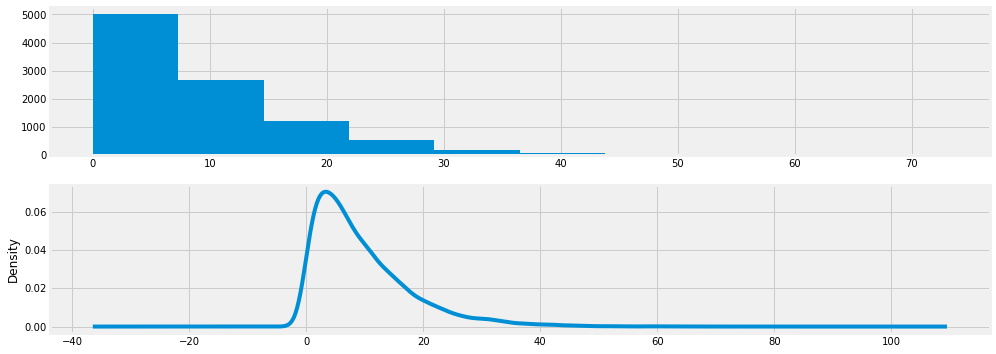

In [9]:
plt.figure(1)
plt.subplot(211)
agg15['count'].hist()
plt.subplot(212)
agg15['count'].plot(kind='kde',figsize=(15, 6))
plt.show();

The median value, the upper quartile, and the max value of login counts at 15-minute intervals have increased over time, with March having the highest values, and April having a slight decrease from March.

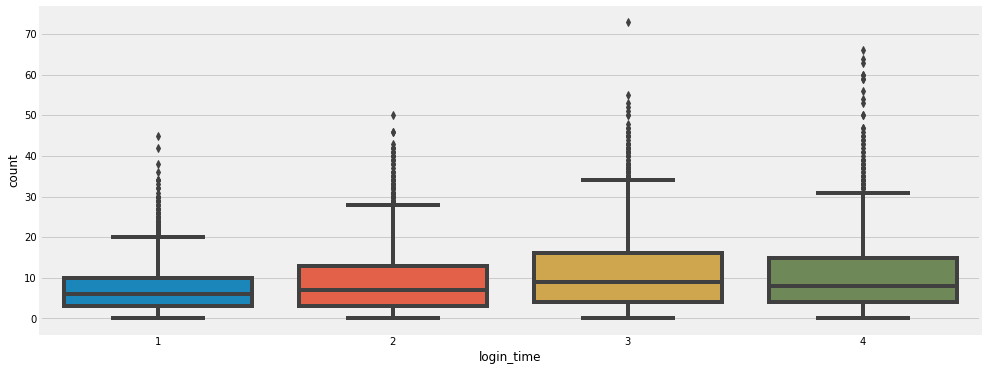

In [10]:
# Box and whisker plot of time series
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(agg15.index.month, agg15['count'], ax=ax);

The time series of login counts at 15-minute intervals from January 1, 1970 to April 13, 1970 has a slight upward trend and strong daily and weekly seasonality. The Trend component shows login counts climbed steadily to a peak in the middle of March from January and went back down to a kind of plateau for the rest of March and April. The Seasonal component of the decomposition shows repeating daily and weekly patterns, possibly corresponding to weekdays and weekends.

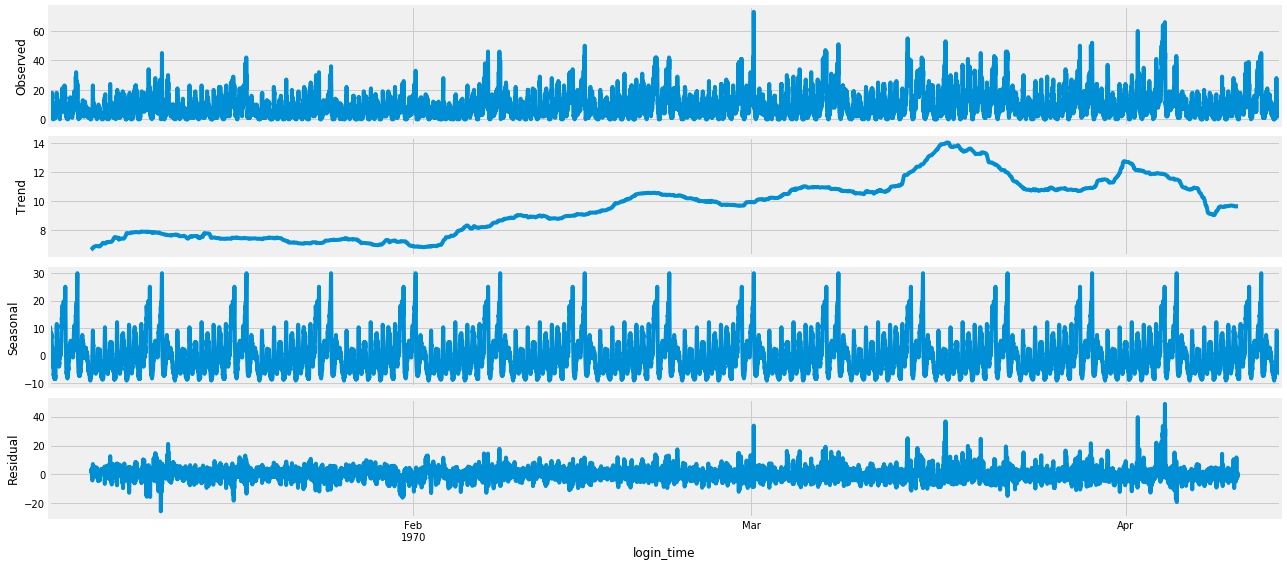

In [11]:
# Decompose time series with weekly frequency
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(agg15, model='additive', freq=96*7)
fig = decomposition.plot()
plt.show()

## Feature Engineering

In [12]:
# Make dataframe from DateTimeIndex
featured = agg15.index.to_frame(index = True)
featured.head()

,login_time
login_time,
1970-01-01 20:00:00,1970-01-01 20:00:00
1970-01-01 20:15:00,1970-01-01 20:15:00
1970-01-01 20:30:00,1970-01-01 20:30:00
1970-01-01 20:45:00,1970-01-01 20:45:00
1970-01-01 21:00:00,1970-01-01 21:00:00


In [13]:
import re
def add_datepart(df, fldname, drop=True):

    """
    Parameters:
    -----------
    df: A pandas data frame. df gain several new columns.
    fldname: A string that is the name of the date column you wish to expand.
        If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
    drop: If true then the original date column will be removed.
    """
    
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
        
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    
    attr = ['Month','Week','Dayofweek', 'Dayofyear','weekofyear','Hour']
    
    for n in attr: 
        df[n] = getattr(fld.dt, n.lower())
        
    if drop: 
        df.drop(fldname, axis=1, inplace=True)

add_datepart(featured,'login_time',False)
featured.head()

,login_time,Month,Week,Dayofweek,Dayofyear,weekofyear,Hour
login_time,,,,,,,
1970-01-01 20:00:00,1970-01-01 20:00:00,1,1,3,1,1,20
1970-01-01 20:15:00,1970-01-01 20:15:00,1,1,3,1,1,20
1970-01-01 20:30:00,1970-01-01 20:30:00,1,1,3,1,1,20
1970-01-01 20:45:00,1970-01-01 20:45:00,1,1,3,1,1,20
1970-01-01 21:00:00,1970-01-01 21:00:00,1,1,3,1,1,21


In [14]:
agg15['dayofweek'] = featured['Dayofweek']
agg15['Month'] = featured['Month']
agg15['Week'] = featured['Week']
agg15['Hour'] = featured['Hour']

## Pivoting
Saturday, day of week 5, has highest login counts, followed closely by Sunday (day of week 6) and Friday (day of week 4). Tuesday, Wednesday, and Thursday had the same sharp spikes in login counts on week 12 of the time series while Saturday and Sunday have slight dips on the same week.

The pivot tables of hours and days show that the most people login over the weekends. On week days, most logins occur from 11am to 12pm. On weekends, most logins occur at night with peaks in the twilight hours of 1 to 4am. 

Over the course of the months, the login counts for all hours climbed to a peak in March from week 12 to week 14. The sharp increases for all hours on week 12 could be due to events or holidays.

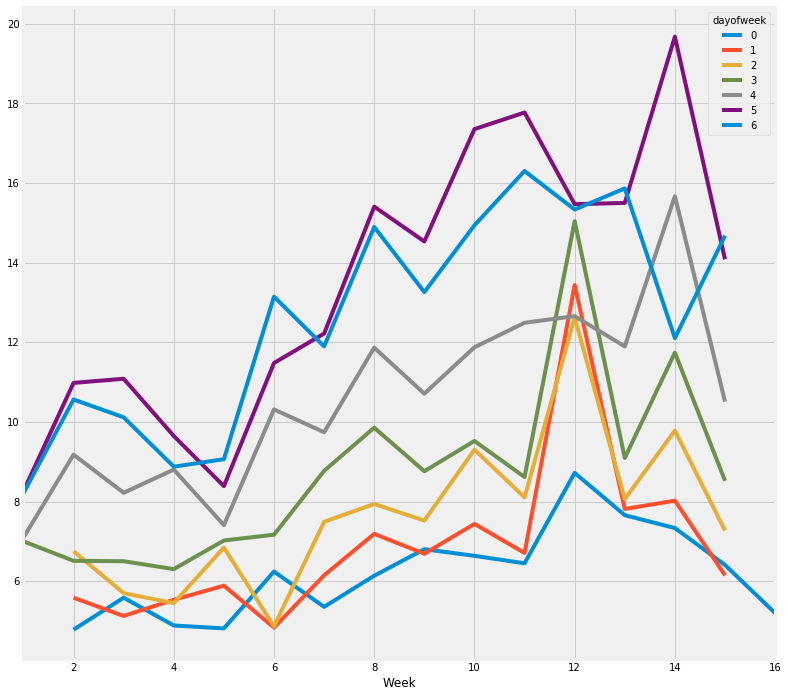

In [15]:
pivoted = pd.pivot_table(agg15, values='count', columns='dayofweek', index='Week')
pivoted.plot(figsize=(12,12));

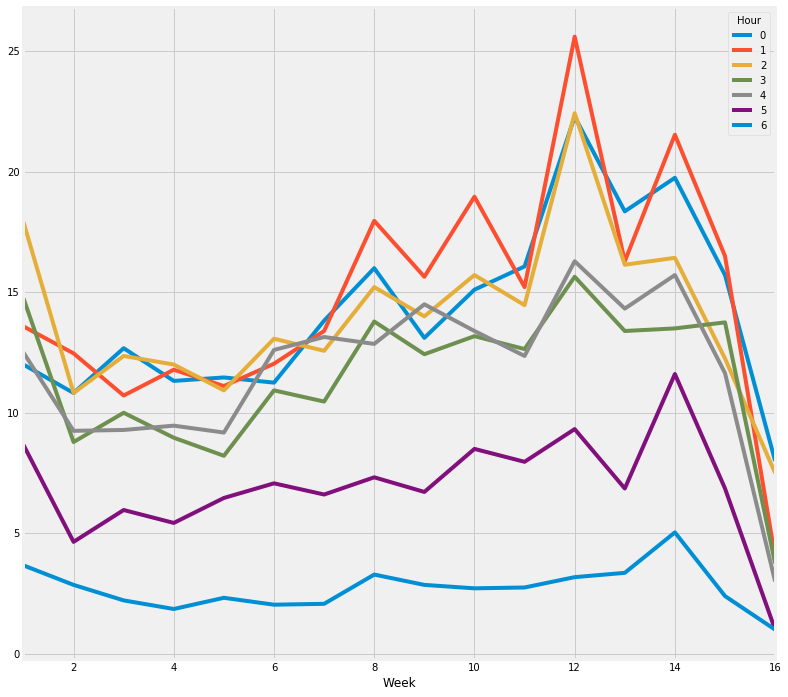

In [16]:
pivoted_week_hours = pd.pivot_table(agg15[(agg15['Hour']>=0)&(agg15['Hour']<7)], values='count', columns='Hour', index='Week')
pivoted_week_hours.plot(figsize=(12,12));

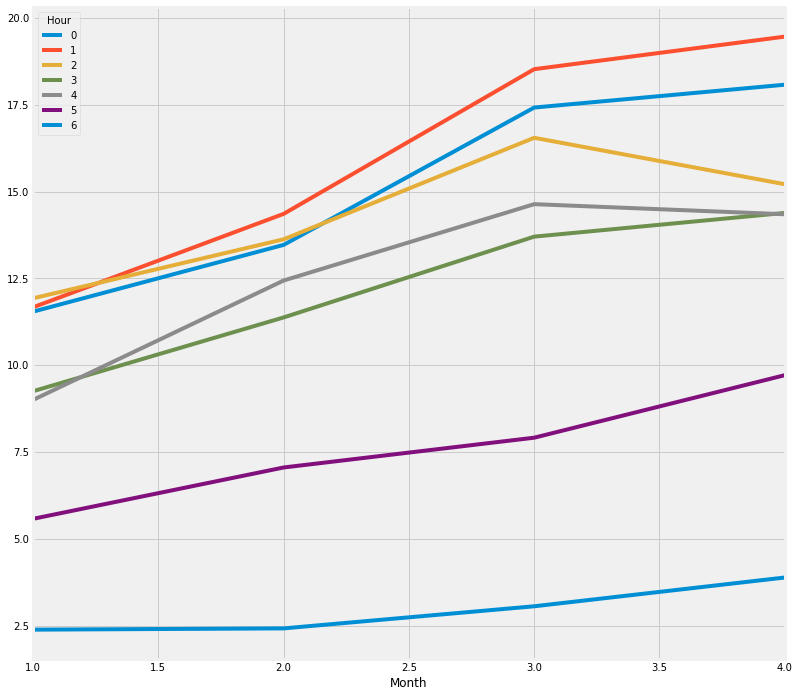

In [17]:
pivoted_month_hours = pd.pivot_table(agg15[(agg15['Hour']>=0)&(agg15['Hour']<7)], values='count', columns='Hour', index='Month')
pivoted_month_hours.plot(figsize=(12,12));

Each day of the week follows similar daily cycles with peaks in the middle of the day and at night. Saturday and Sunday climb to sharp peaks in the twilight hours around 4am from 8pm and drops back down to a trough in the morning around 8 to 9am. Monday to Friday climb to a peak in the middle of the day around 11am to 12pm from 6am, and drop back down to a trough around 5 to 6pm.

On the week days from Monday to Friday, or day of week 0 to 4, login counts are high around 11am to 12pm and very low around 7 to 8am. The afternoon hours from 1 to 5pm follow the same trend throughout the week with less logins during the week days and more logins closer to the weekend. All afternoon hours have noticeable increases in login count from Friday to Saturday, with Saturday and Sunday having the most login counts in the afternoons.

The evenings from 6 to 11pm also follow the same pattern throughout a week. All evening hours login counts climbed to a peak on Friday from Monday then dropped back down on Saturday and Sunday. 9 to 11pm on Fridays appears to have a rush of logins. Twilight hours have low login counts from Monday to Friday with a sharp increase on Saturday and Sunday. 4am on Sunday has the most logins out of all the hours. 

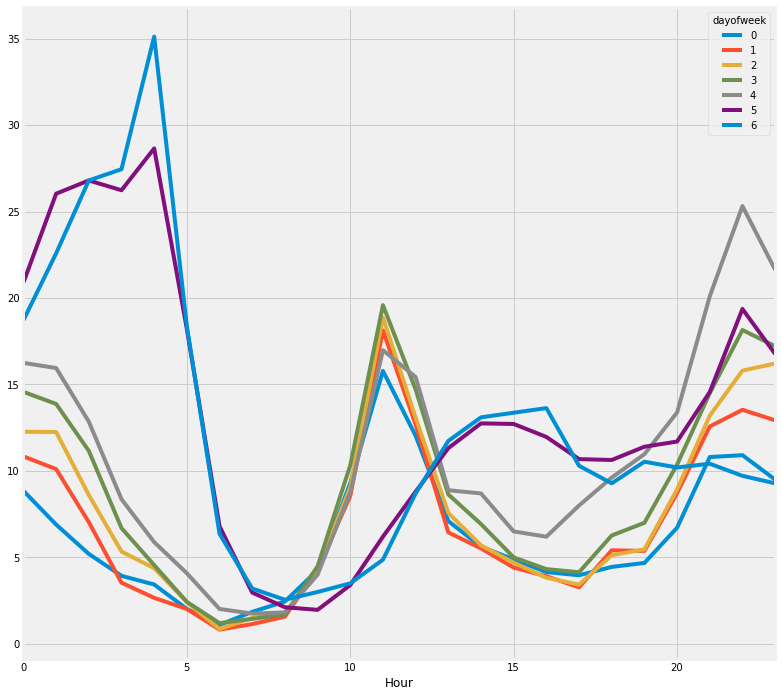

In [18]:
pivoted_hours_day = pd.pivot_table(agg15, values='count', columns='dayofweek', index='Hour')
pivoted_hours_day.plot(figsize=(12,12));